<a href="https://colab.research.google.com/github/Yash-10/ML4SCI2021-Strong-Lensing/blob/main/Grav_Lensing_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown

In [ ]:
# Download Dataset
!gdown http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
!unzip -q dataset.zip

Downloading...
From: http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /content/dataset.zip
100% 1.13G/1.13G [00:10<00:00, 103MB/s]


In [ ]:
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import label_binarize

Samples with no substructure: 


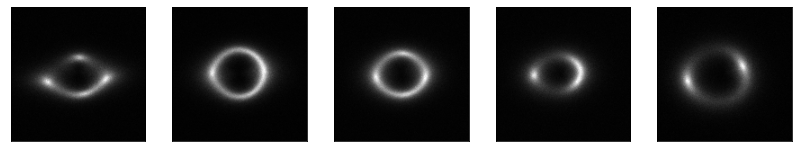

Samples with spherical substructure: 


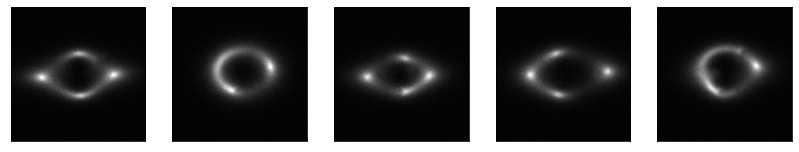

Samples with vortex substructure: 


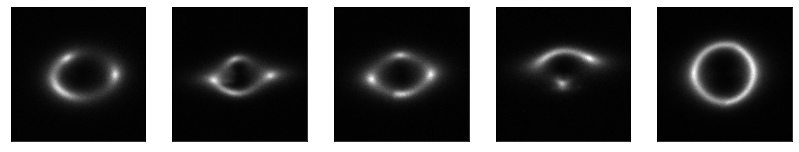

In [ ]:
# Define the input paths
train_path1 = './dataset/train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './dataset/train/sphere'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './dataset/train/vort'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files1[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files2[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files3[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

In [ ]:
import torch
import torchvision
from torch.utils import data
import torch.nn as nn
from torchvision import transforms

import torch.optim as optim
from torch.autograd import Variable

In [ ]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean

#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size()) * self.std + self.mean

Using shear, stretch, resize, or other transformations that could change the shape of the substructure are not used since they could confuse the model.

In [ ]:
# gaussian_noise = transforms.RandomApply(transforms=[AddGaussianNoise(mean=0.5, std=0.2)], p=0.3)
transformations = transforms.Compose(
    [
      transforms.RandomRotation(degrees=90),  # Randomly rotate using angle in the range [-90, +90]
      transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),  # Deactivate rotations, only translations.
      transforms.ToTensor(),
#       transforms.RandomApply(transforms=[AddGaussianNoise(mean=0.5, std=0.2)], p=0.3),
      # transforms.Normalize(mean=(0.5,), std=(0.25,))
    ]
)

In [ ]:
# Set Batch Size
batch_size = 100

to_pil = transforms.ToPILImage()

# Define Data Loaders
def npy_loader(path):
  # https://discuss.pytorch.org/t/loading-npy-files-using-torchvision/28481/3
  sample = to_pil(torch.from_numpy(np.load(path)))
  return sample

def test_dataset_loader(path):
  return np.load(path)

train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy', transform=transformations)
print("Training Classes: " + str(train_data.class_to_idx))
test_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=test_dataset_loader, extensions='.npy')
print("Validation Classes: " + str(test_data.class_to_idx))
test_data_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


In [ ]:
len(train_data), len(test_data)

(30000, 7500)

In [ ]:
total = len(train_data)
trainset, valset = torch.utils.data.random_split(train_data, lengths=[int(total*0.9), int(total*0.1)])
len(trainset), len(valset)

(27000, 3000)

**Notation**: The provided training dataset was split to be used for training and validation. The provided validation dataset (`/content/dataset/val`) is used for the final evaluation.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    trainset, num_workers=2, batch_size=64, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    valset, num_workers=2, batch_size=64, shuffle=True
)

In [ ]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def use_pretrained_model(pretrained=True, requires_grad=False):
  model = models.resnet34(progress=True, pretrained=pretrained)
  if requires_grad == False:
    for param in model.parameters():
        param.requires_grad = False
  elif requires_grad == True:
    for param in model.parameters():
        param.requires_grad = True

  # Make the first convolutional layer take one channel.
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  # Adapt the classification layer to our task.
  model.fc = nn.Linear(512, 3, bias=True)
  return model

model = use_pretrained_model(requires_grad=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

grad_clip = None
num_epochs = 40

datasets = {'train': train_dataloader.dataset, 'val': val_dataloader.dataset}
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {x: len(datasets[x]) for x in dataloaders.keys()}

def train_model(model, dataloaders, optimizer, scheduler=None, num_epochs=30, grad_clip=None):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 5  # Stop if no decrement in validation loss after 4 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    train_losses = []
    val_losses = []

    # best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train and validate for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for images, labels in dataloaders[phase]:
              # Zero parameter gradients.
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        if grad_clip is not None:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * images.size(0)
                    running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'val':
              scheduler.step(epoch_loss)

            ### Early Stopping ###
            if phase == "val" and epoch_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
                epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
                print("Early stopping!")
                return train_losses, val_losses  # Way to come out of all nested loops
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss} Accuracy: {epoch_acc}')

            if phase == 'val' and epoch_loss == min_val_loss:  # Check for equality because we set min_val_loss = epoch_loss if indeed loss decreased.
                # Save best model weights in a file.
                print("Val loss decreased, saving model file")
                torch.save(model.state_dict(), 'grav_lensing_classification_model_colab.pth')

        print()

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(
    model, dataloaders, optimizer, scheduler=scheduler, num_epochs=num_epochs, grad_clip=grad_clip,
)

Epoch 0/39
----------
train Loss: 1.1253596638926753 Accuracy: 0.34744444444444444
val Loss: 1.1254965295791626 Accuracy: 0.35933333333333334
Val loss decreased, saving model file

Epoch 1/39
----------
train Loss: 1.0276030791600546 Accuracy: 0.4431851851851852
val Loss: 0.9919474275906881 Accuracy: 0.497
Val loss decreased, saving model file

Epoch 2/39
----------
train Loss: 0.8473597016157928 Accuracy: 0.5930740740740741
val Loss: 0.7795290549596151 Accuracy: 0.632
Val loss decreased, saving model file

Epoch 3/39
----------
train Loss: 0.6642218205487287 Accuracy: 0.709037037037037
val Loss: 0.5593594479560852 Accuracy: 0.7736666666666666
Val loss decreased, saving model file

Epoch 4/39
----------
train Loss: 0.5447783922089471 Accuracy: 0.773074074074074
val Loss: 0.5078010249137879 Accuracy: 0.785
Val loss decreased, saving model file

Epoch 5/39
----------
train Loss: 0.4821450063387553 Accuracy: 0.8049259259259259
val Loss: 0.4449735836982727 Accuracy: 0.8233333333333334
Val 

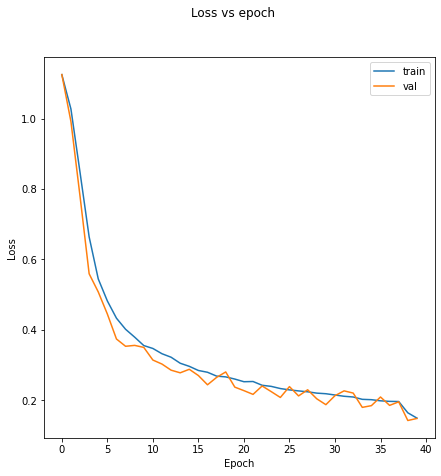

In [ ]:
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots(1, 1)

fig.suptitle("Loss vs epoch");
ax.plot(train_losses, label='train');
ax.plot(val_losses, label='val');
ax.set_ylabel("Loss");
ax.set_xlabel("Epoch");
ax.legend();

In [ ]:
model = use_pretrained_model(pretrained=False, requires_grad=False)
model.load_state_dict(torch.load("grav_lensing_classification_model_colab.pth"))

<All keys matched successfully>

In [ ]:
model.eval()
y_score = []
y_test = []
for _, (x_ts, y_ts) in enumerate(test_data_loader):
    # if torch.cuda.is_available():
    #   mini_val_data = mini_val_data.cuda()
    y_score.append(torch.nn.functional.softmax(model(x_ts.float()), dim=1).cpu().detach().numpy())
    y_test.append(y_ts.cpu().detach().numpy())

y_score = np.asarray(y_score).reshape(-1,3)
y_val = np.asarray(y_test).reshape(-1)
y_val = label_binarize(y_val, classes=[0, 1, 2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


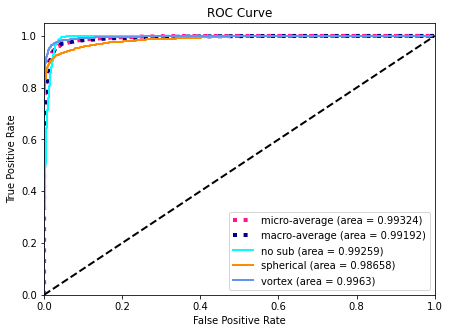

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle


n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})

In [ ]:
print(f"AUC score: {roc_auc_score(y_val, y_score)}")

AUC score: 0.9918256533333333


In [ ]:
# Save in drive
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/grav_lensing_classification_model_colab.pth /content/gdrive/MyDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The modek file can be found at: https://drive.google.com/file/d/1z3bS0qmaa6uBAPnvv4ZRHqUhdoxABzGa/view

### References

1. *Alexander, S., Gleyzer, S., McDonough, E., Toomey, M., & Usai, E. (2020). Deep Learning the Morphology of Dark Matter Substructure. The Astrophysical Journal, 893(1), 15. doi: 10.3847/1538-4357/ab7925*